In [1]:
%env CUDA_VISIBLE_DEVICES=0
import torch
import torchvision as tv
from torchvision import datasets, transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#import torch_dip_utils as utils
import utils
import math

env: CUDA_VISIBLE_DEVICES=0


# IMPORT SOME STUFF FROM DIP REPO

In [2]:
from dip.models.__init__ import get_net
from dip.utils.common_utils import get_noise
from dip.models.downsampler import Downsampler

In [3]:
ALEX_BATCH_SIZE = 1 # batch size of gradient step

CUDA = torch.cuda.is_available()
print(CUDA)

#save the correct datatype depending on CPU or GPU execution
if CUDA : 
    dtype = torch.cuda.FloatTensor  
    print(torch.cuda.device(0))
else:
    dtype = torch.FloatTensor
    print("NO DEVICES")
    
grayscale = True
if grayscale:
    nc = 1
else:
    nc = 3 #rgb
    
IMG_SIZE = 256 # pixel height x width

True


In [4]:
# DEFINE COMPOSE - resize, convert to torch tensor, normalise assuming mean,std = 0.5 across all channels (to improve contrast)
compose = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((.5,.5,.5),(.5,.5,.5))
])

# LOAD IMAGE(S) INTO PYTORCH OBJECT

In [5]:
#grab the image(s)
alexset = datasets.ImageFolder('data/tomo/' , transform = compose) # NOTE - image folder must contain subfolders, cannot contain direct images
alexloader = torch.utils.data.DataLoader(alexset, shuffle=True, batch_size=ALEX_BATCH_SIZE)
alexiter = iter(alexloader)
alex_batch_iter = alexiter.next()

# UTILITY FUNCTIONS + PLOT ORIGINAL IMAGE

torch.Size([1, 3, 256, 256])
(256, 256, 3)


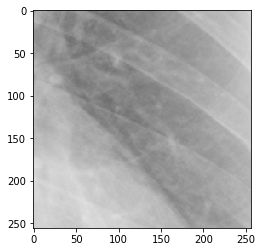

In [6]:
#renormalise the image (used to display original image and to renormalise GAN output)
def renorm(x):
    return 0.5*x + 0.5

def plot(x, renormalize=True):
    if renormalize:
        im = renorm(x).data.cpu().numpy().transpose((1,2,0))
        if grayscale:
            plt.imshow(im, cmap='gray')
        else:
            print('')
    plt.imshow(im)
    return im

for x in alexloader:
    data,label = x
    data = Variable(data.type(dtype))
    print(data.shape)
    label = label.type(dtype)
    
    if grayscale == False:
        d_new = data[0]
        im_orig = plot(d_new)#view(IMG_SIZE,IMG_SIZE,3))
    else:
        im_orig = plot(data[0])
    
if grayscale:
    plt.imshow(im_orig, cmap='gray')
else:
    plt.imshow(im_orig)
    
print(im_orig.shape)

In [7]:
alex_batch = alex_batch_iter[0] # select the first (and only) image from the loader
alex_batch = Variable(alex_batch.type(dtype)) # use correct type - must be cuda.FloatTensor if using GPU

#get rid of extra RGB channels
if grayscale:
    alex_batch = alex_batch[0][0] # for [0][0] - first dimension is batch size, second selects channel (3 and 4 are image H and W)
    
print("Image Size: ", alex_batch.shape)

Image Size:  torch.Size([256, 256])


In [8]:
mse = torch.nn.MSELoss().type(dtype)

# FIX HYPERPARAMS

In [9]:
LR = 1e-3 # learning rate
MOM = 0.9 # momentum
NUM_ITER = 500 # number iterations - SHOULD BE 500
WD = 1e-4 # weight decay for l2-regularization
THRESH = 0.0
LOG_FREQ = 100 # frequency at which to display image during training

num_measurements = 2000

Z_NUM = 32 # input seed
NGF = 64 # number of filters per layer

# DEFINE NETWORK

In [10]:
class DCGAN(nn.Module):
    def __init__(self, nz, ngf=64, output_size=256, nc=3, num_measurements=1000):
        super(DCGAN, self).__init__()
        self.nc = nc
        self.output_size = output_size

        self.conv1 = nn.ConvTranspose2d(nz, ngf, 4, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(ngf)
        self.conv2 = nn.ConvTranspose2d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn2 = nn.BatchNorm2d(ngf)
        self.conv3 = nn.ConvTranspose2d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn3 = nn.BatchNorm2d(ngf)
        self.conv4 = nn.ConvTranspose2d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn4 = nn.BatchNorm2d(ngf)
        self.conv5 = nn.ConvTranspose2d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn5 = nn.BatchNorm2d(ngf)
        self.conv6 = nn.ConvTranspose2d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn6 = nn.BatchNorm2d(ngf)
        self.conv7 = nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False) #output is image
       
        self.fc = nn.Linear(output_size*output_size*nc,num_measurements, bias=False) #output is A
        # each entry should be drawn from a Gaussian
        # don't compute gradient of self.fc! memory issues
   
    def forward(self, x):
        input_size = x.size()
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.tanh(self.conv7(x,output_size=(-1,self.nc,self.output_size,self.output_size)))
       
        return x
   
    def measurements(self, x):
        # this gives the image
        # make it a single row vector of appropriate length
        y = self.forward(x).view(1,-1)
        y = y.cpu()
        #passing it through the fully connected layer
        # returns A*image
        if CUDA:
            meas = self.fc(y)
            return meas.cuda()
        else:
            return self.fc(y)

# SET UP NETWORK STUFF

In [11]:
# get a DCGAN that outputs images of size img_size
net = DCGAN(Z_NUM,NGF,IMG_SIZE,nc,num_measurements) # initialize network
net.fc.requires_grad = False

if CUDA: # move network to GPU if available
    net.cuda()
    print("USING CUDA")
else:
    print("RUNNING ON CPU")
    
# initialize fully-connected layer weights as our matrix A    
# A_tensor: gaussian(0,1) entries in matrix of dim'n R^(num_meas x (img_size x img_size x num_channels))
net.fc.weight.data = (1/math.sqrt(1.0*num_measurements)) * \
                    torch.randn(num_measurements, IMG_SIZE*IMG_SIZE*nc)

allparams = [x for x in net.parameters()] #specifies which to compute gradients of
allparams = allparams[:-1] # get rid of last item in list (fc layer) because it's memory intensive


# Define input seed z as Torch variable, normalize
z = Variable(torch.zeros(ALEX_BATCH_SIZE*Z_NUM).type(dtype).view(ALEX_BATCH_SIZE,Z_NUM,1,1))
z.data.normal_().type(dtype)

# Define optimizer
optim = torch.optim.RMSprop(allparams,lr=LR,momentum=MOM, weight_decay=WD)

USING CUDA


In [12]:
print(z.shape)

torch.Size([1, 32, 1, 1])


In [13]:
# Create measurements y, move to Torch variable
# torch.mm does matrix multiplication on a flattened row-major version of the image (R^H*W*Ch) and A^T (R^(H*W*Ch)X(measurements)) to produce a R^(measurements vector)
alex_measurements = Variable(torch.mm(alex_batch.cpu().data.view(ALEX_BATCH_SIZE,-1),net.fc.weight.data.permute(1,0)),requires_grad=False) 

if CUDA: # move measurements to GPU if possible
    alex_measurements = alex_measurements.cuda()

In [14]:
print(alex_measurements.shape)

torch.Size([1, 2000])



# OPTIMIZE NETWORK
### SRIRAM: WOULD NEED TO FIX mse_log name to obtain MSE at each iteration and graph convergence

/home/sravula/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


499 tensor(0.0002, device='cuda:0')


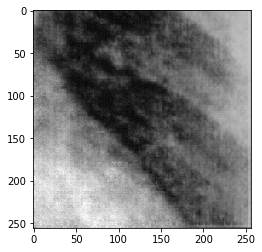

177.66251707077026


In [15]:
import time

# Create numpy logs to store images, MSE values for each iteration
mse_log = np.zeros((NUM_ITER))#, nc))
im_log = np.zeros((NUM_ITER, IMG_SIZE, IMG_SIZE))#, nc))

start = time.time()

for i in range(NUM_ITER):
    optim.zero_grad() # clears graidents of all optimized variables
    out = net(z) # produces image (in form of data tensor) i.e. A*G(z)
    loss = mse(net.measurements(z),alex_measurements) # calculate loss
         
    # DCGAN output is in [-1,1]. Renormalise to [0,1] before plotting
    if grayscale:
        im = utils.renorm(out).data[0].cpu().numpy() 
    else:
        im = utils.renorm(out).data[0].cpu().numpy().transpose((1,2,0))

        
    im_log[i] = im # save image to image_log
    mse_log[i] = np.mean((im[0] - im_orig[:,:,0]) ** 2) # @Sriram: fix dimensionality error to record MSE
    
    if i == NUM_ITER - 1:
        print(i,loss.data)
        
        if grayscale: # reshape array to be proper size for imshow
            plt.imshow(np.squeeze(im, axis=0), cmap = 'gray') 
        else: # array should be (img_size x img_size x nc=3)
            plt.imshow(im)
        plt.show()
        
    
    loss.backward()
    optim.step()
    
end = time.time()
print(end-start)

# PRINT MSE VALUES 

Index     157
Min MSE:  4.477e-04
Last MSE: 4.8659e-04


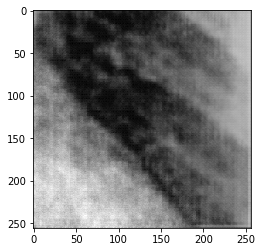

In [16]:
from decimal import Decimal 

# format value n (to 4 decimal pts) for easy visualization
def format_e(n, dec=4, is_hparam = False): 
    a = '%E' % n
    pre = a.split('E')[0].rstrip('0').rstrip('.')
    pre = str(round(float(pre), dec))
    if is_hparam == True:
        pre = str(int(float(pre))) # get rid of decimal
    return pre + 'e' + a.split('E')[1]
    
min_idx = np.argmin(mse_log) # find iteration with lowest loss
im_best = im_log[min_idx] # get corresponding image
min_mse = format_e(mse_log[min_idx]) # get corresponding mse
last_mse = format_e(mse_log[NUM_ITER-1]) # get mse of last iter'n

print('Index     ' + str(min_idx))
print('Min MSE:  ' + str(min_mse))
print('Last MSE: ' + str(last_mse))

plt.imshow(im_best, cmap = 'gray') 
plt.show()

# PRINT MSE vs. ITERATIONS

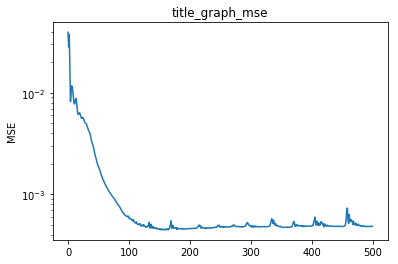

In [17]:
from matplotlib import pyplot as plt
from matplotlib.axes import Axes

itern = np.arange(NUM_ITER) #iteration

#MSE graph
plt.figure()
plt.ylabel('MSE')
plt.title('title_graph_mse')
plt.semilogy(itern, mse_log)